In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference')
print(os.getcwd())

/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference


In [2]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import trimesh
from tqdm.autonotebook import tqdm
from pytorch3d.io import save_obj
import pandas as pd
import imageio

from utils import general_utils, visualization_tools, eval_utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1, sample_points
from utils.brute_force_pose_est import brute_force_estimate_pose, brute_force_estimate_dist
from mesh_refiner import MeshRefiner

In [3]:
# pix3d occnet gt
dataset = "shapenet"
class_name = "03001627"
instance = "ee4858f78dc33591100e9bd5c4b0af54"
cfg_path = "configs/sim_pipeline_01.yaml"


if dataset == "pix3d":
    rec_dir_name = "pix3d"
    img_dir_name = "pix3d_images_processed_filtered"
else:
    rec_dir_name = "pytorch3d_renders"
    img_dir_name = "pytorch3d_shapenet_renders"
input_img_dir = "data/input_images/{}/{}/rgba".format(img_dir_name, class_name)
input_img_path = os.path.join(input_img_dir, "{}.png".format(instance))
input_mesh_path = "/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/{}/{}/generation/meshes/{}.obj".format(rec_dir_name, class_name, instance)
gt_pose_dict = pickle.load(open(os.path.join(input_img_dir, "renders_camera_params.pt"), "rb"))[instance]
device = torch.device("cuda:0")
cfg = general_utils.load_config(cfg_path, "configs/default.yaml")

print(input_img_path)
print(input_mesh_path)
pprint.pprint(gt_pose_dict)

data/input_images/pytorch3d_shapenet_renders/03001627/rgba/ee4858f78dc33591100e9bd5c4b0af54.png
/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/occupancy_networks/out/pytorch3d_renders/03001627/generation/meshes/ee4858f78dc33591100e9bd5c4b0af54.obj
{'azim': 302.7176818847656, 'dist': 1.0, 'elev': 40.0}


In [4]:
input_image = np.asarray(Image.open(input_img_path))
mask = np.asarray(input_image)[:,:,3] > 0
with torch.no_grad():
    input_mesh = general_utils.load_untextured_mesh(input_mesh_path, device)

elev = gt_pose_dict["elev"]
azim = gt_pose_dict["azim"]
_, _, dist, _, _ = brute_force_estimate_dist(input_mesh, mask, azim, elev, 40, device)

In [5]:
mesh_refiner = MeshRefiner(cfg, device)
refined_meshes, loss_info = mesh_refiner.refine_mesh(input_mesh, input_image, dist, elev, azim, record_intermediate=True)

Epoch REFINEment: 0


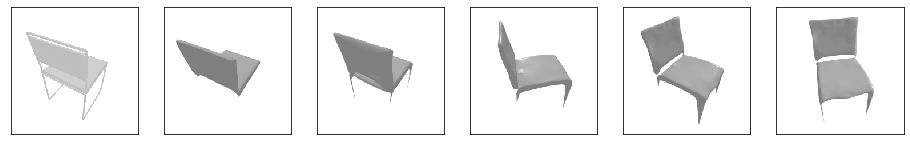

Epoch REFINEment: 30


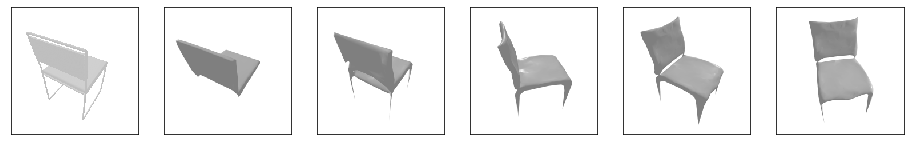

Epoch REFINEment: 60


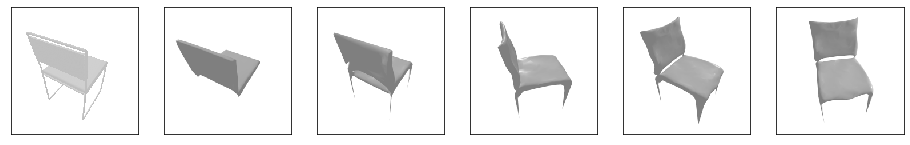

Epoch REFINEment: 90


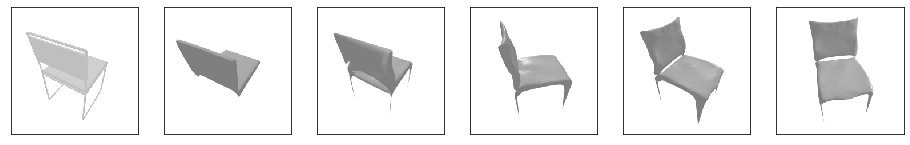

Epoch REFINEment: 120


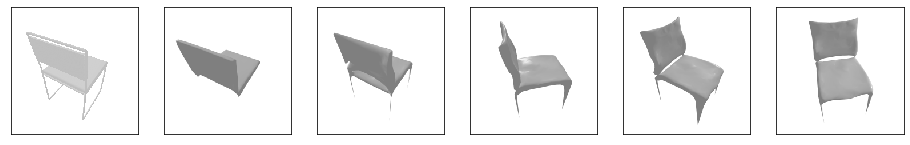

Epoch REFINEment: 150


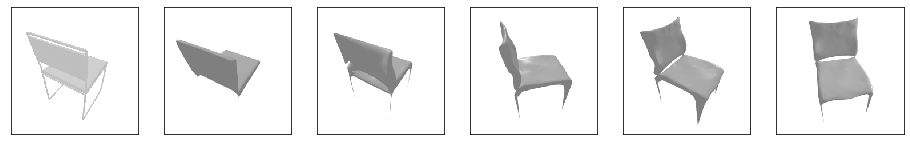

Epoch REFINEment: 180


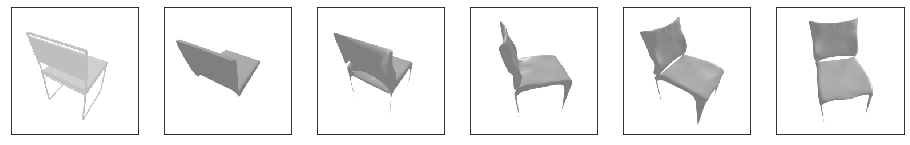

Epoch REFINEment: 210


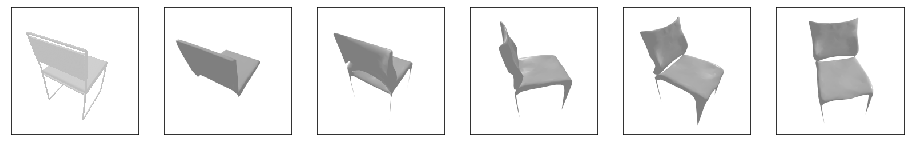

Epoch REFINEment: 240


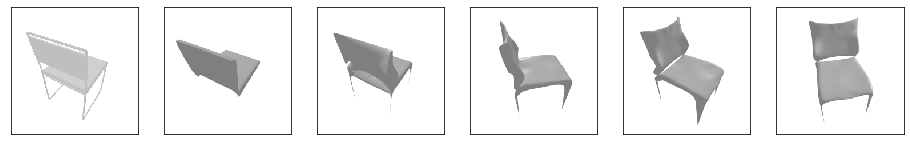

Epoch REFINEment: 250


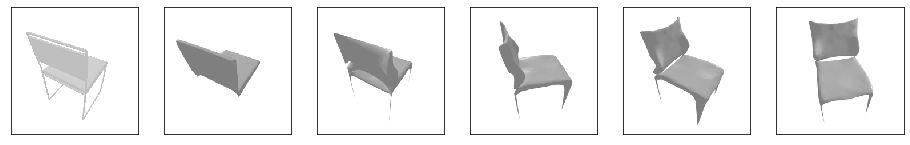

In [6]:
show_every = 30
for i, refined_mesh in enumerate(refined_meshes):
    if i % show_every == 0 or i == len(refined_meshes)-1:
        print("Epoch REFINEment: {}".format(i))
        visualization_tools.show_refinement_results(input_image, input_mesh, refined_mesh.to(device), dist, elev, azim, device)


Text(0, 0.5, 'Total Loss')

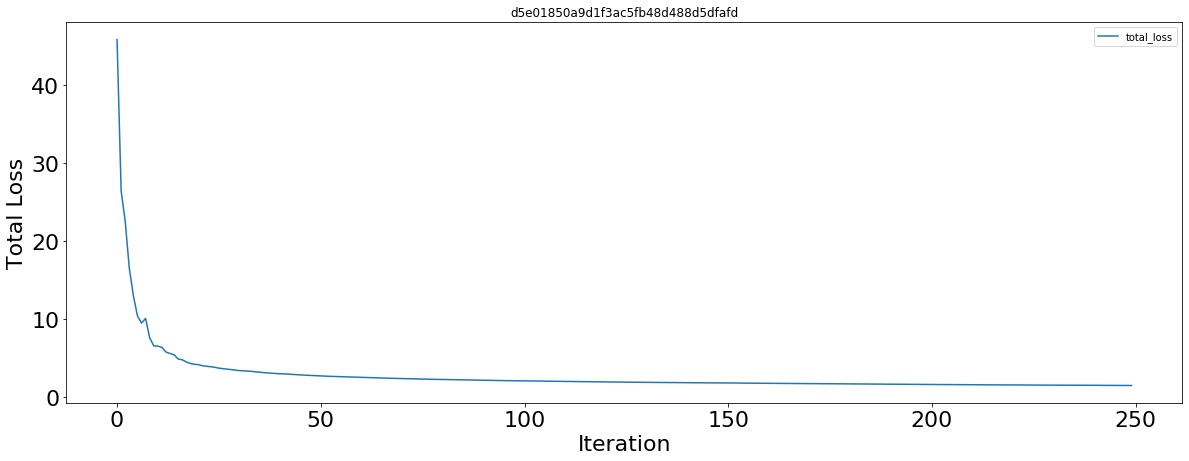

In [17]:
ax = loss_info["loss_info"].plot.line(x='iteration', y='total_loss', title="{}".format(instance), figsize=(20,7), fontsize=22)
plt.xlabel("Iteration", fontsize=22)
plt.ylabel("Total Loss", fontsize=22)

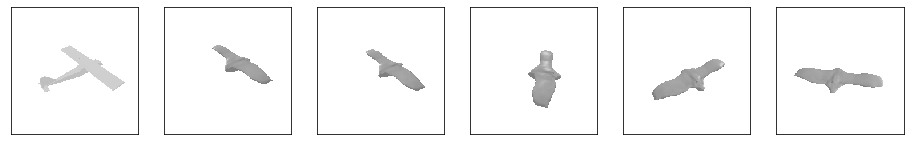

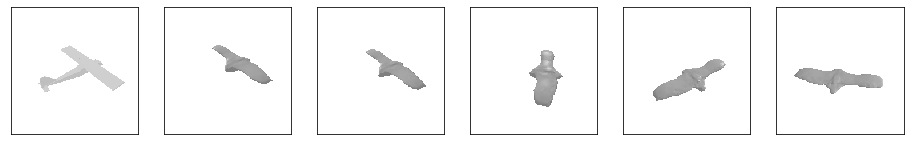

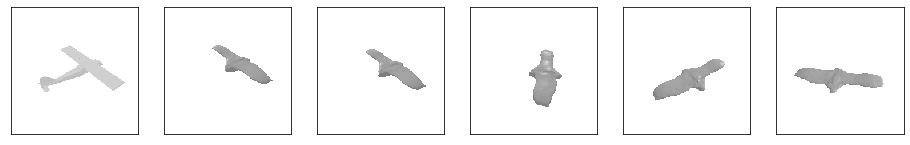

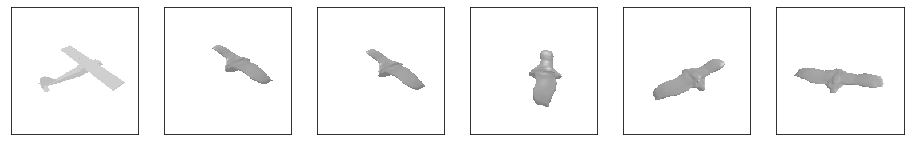

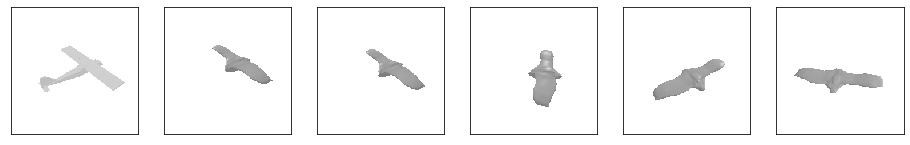

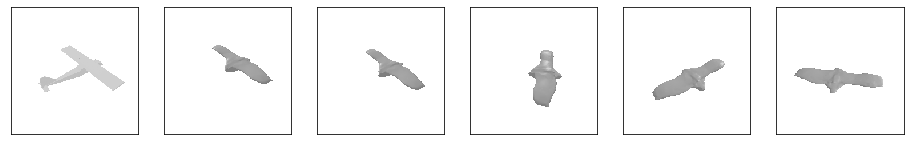

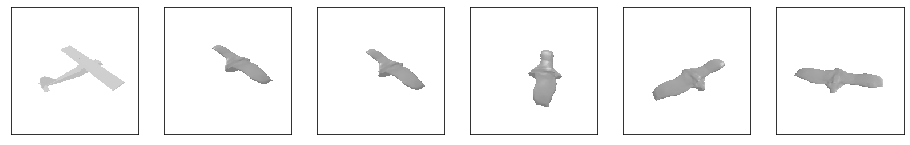

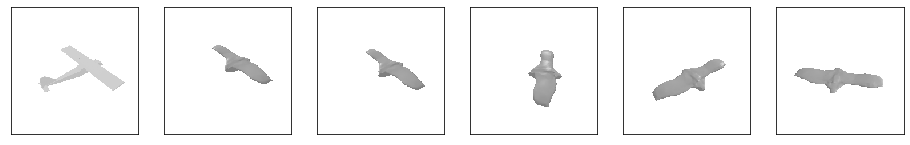

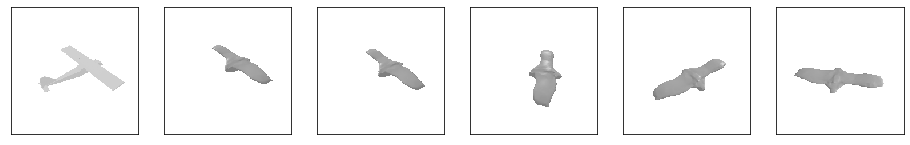

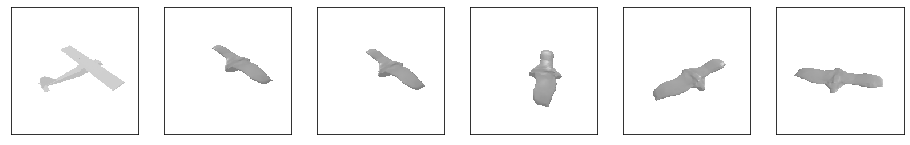

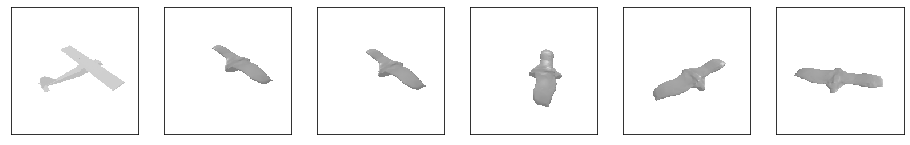

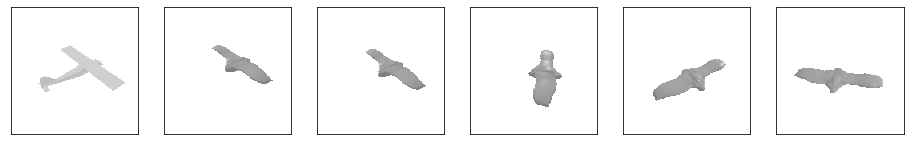

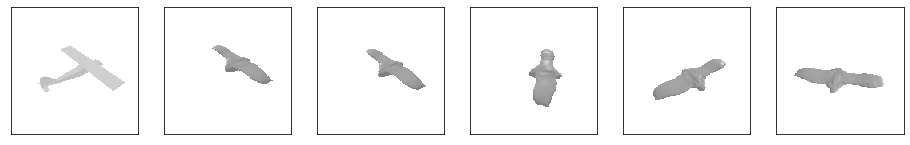

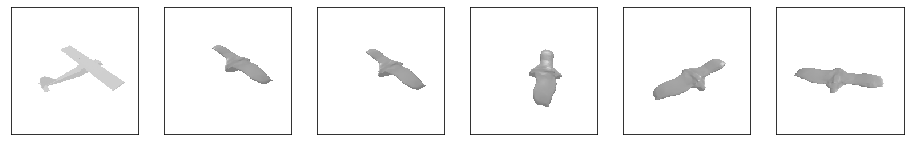

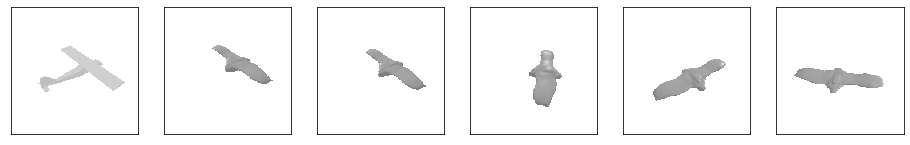

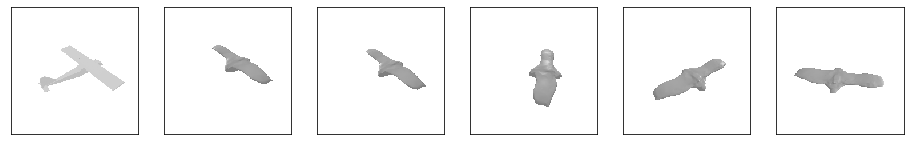

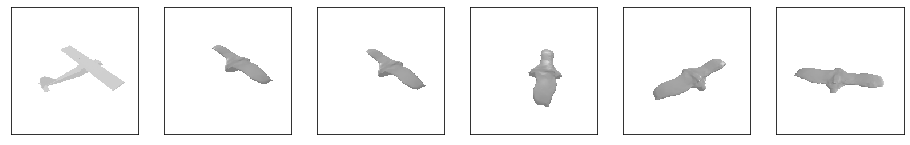

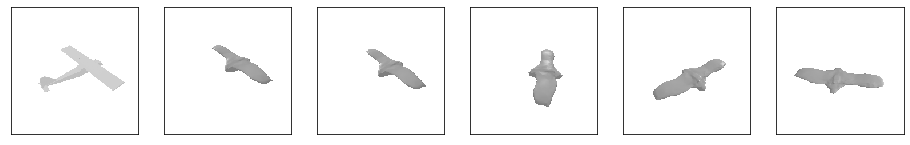

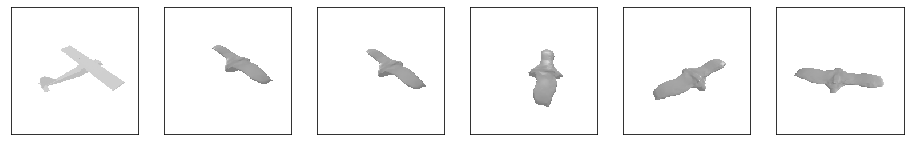

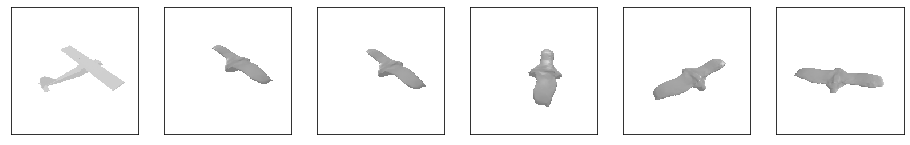

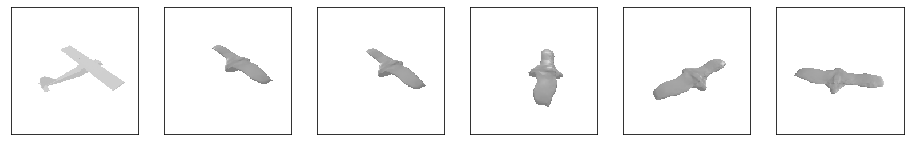

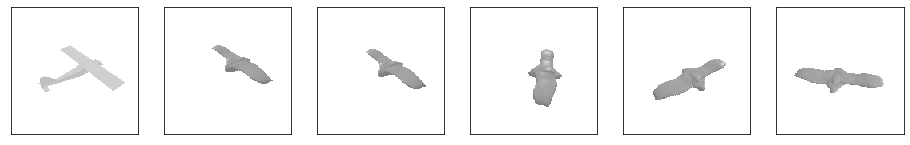

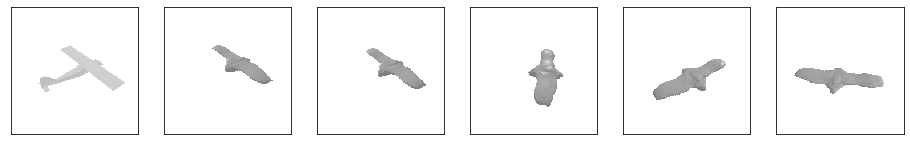

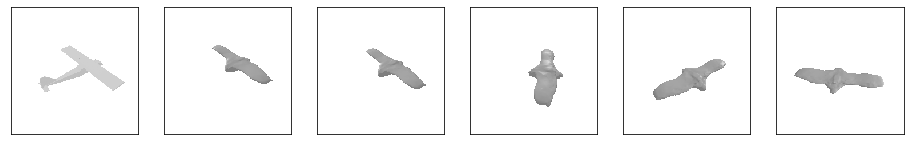

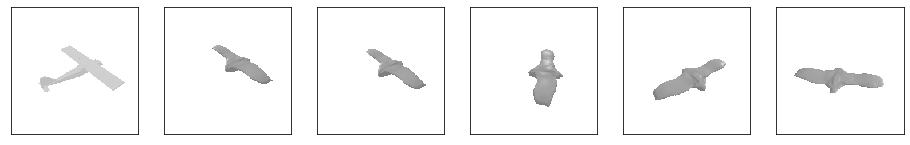

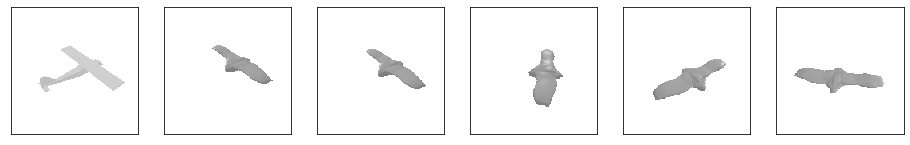

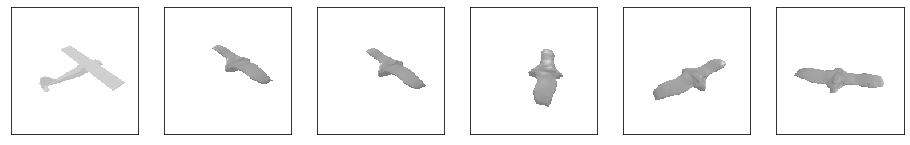

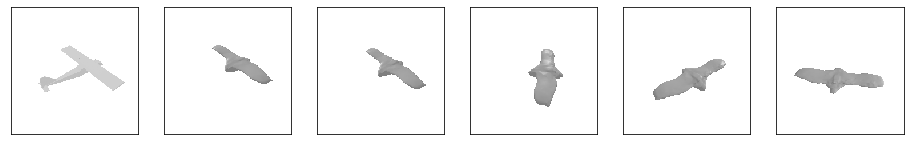

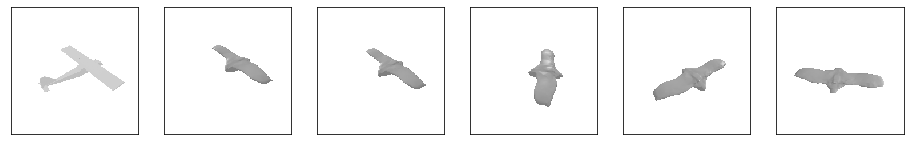

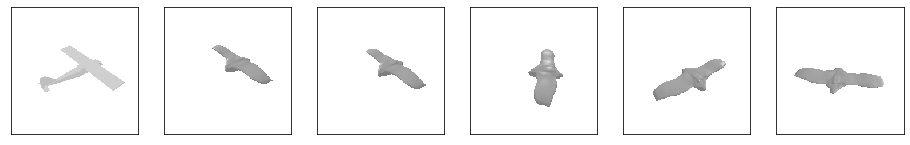

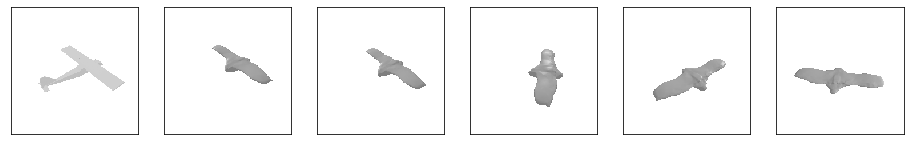

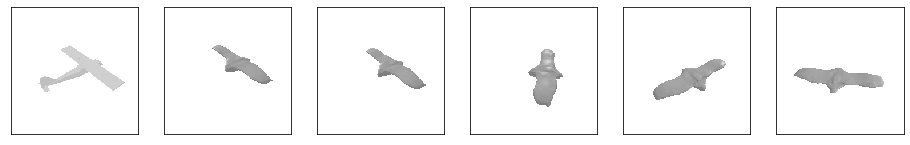

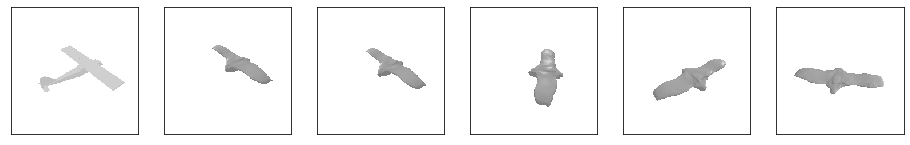

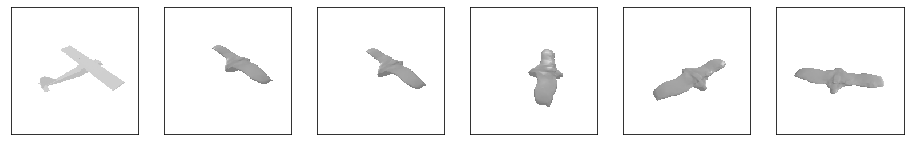

KeyboardInterrupt: 

In [12]:
# create GIF
filename_output = "notebooks/visualization_outputs/refinement_progress_{}_{}_{}.gif".format(dataset, class_name, instance)
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

for refined_mesh in refined_meshes:
    img = visualization_tools.show_refinement_results(input_image, input_mesh, refined_mesh.to(device), dist, elev, azim, device)
    writer.append_data(img)

writer.close()

In [ ]:
plt.imshow(img)